In [32]:
from keras.layers import Dense, InputLayer
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD
import numpy as np
import matplotlib as mpl
from talk_plottingutils import plot_3d
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# conda create --name py36_keras anaconda python=3.6
# source activate py36_keras
# pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-1.3.0-cp36-cp36m-linux_x86_64.whl
# https://www.tensorflow.org/install/
# pip install keras

# Introduction

A multilayer perceptron is a simple extension of logistic regression:
## logistic regression: 
- mapping the input directly to output: 
- **linear** decision boundary
![logreg](images/MLP/logreg.png)

## Multilayer perceptron:
- we add another layer in between input and output
- this **hidden layer** allows us to learn a different **representation of the input data**
- the data might be linearly separable in the hidden layer, even though it wasnt in the input space
![mlp](images/MLP/MLP.png)


# A new dataset
not linearly separable, so logistic regression will fail

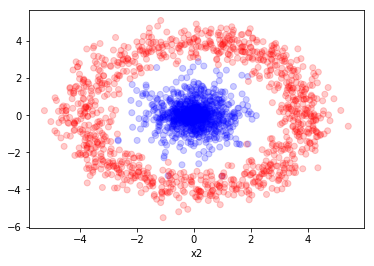

In [3]:
from talk_utils import create_nonlin_data
X, y = create_nonlin_data(1000)
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.2, cmap=plt.cm.bwr); plt.xlabel('x1'), plt.xlabel('x2');

# Keras
Instead of implementing the MLP from scratch (calculating all the gradients etc), let's use [keras](https://keras.io), a high level library for NNs.

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

def MLP_factory():
    MLP = Sequential()

    #input layer
    MLP.add(InputLayer(input_shape=(2,), name='input_layer'))

    # hidden layer with 3 neurons/units
    MLP.add(Dense(units=3, name='hidden_layer', activation='sigmoid', input_shape=(2,)))

    # output layer, outputs two class probabilities
    MLP.add(Dense(units=2, name='output_layer', activation='softmax'))

    return MLP

MLP = MLP_factory() 
MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2)                 0         
_________________________________________________________________
hidden_layer (Dense)         (None, 3)                 9         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


before we fit it, we must 'compile' the model and define the type of optimization algorithm


In [53]:
# define a loss function and optimizer
MLP.compile(loss='categorical_crossentropy',
              optimizer='adam',     # or 'sge' as simplest case
              metrics=['accuracy'])

In [61]:
MLP.fit(X,to_categorical(y), epochs=20)

Epoch 1/20
2000/2000 [==============================] - 0s - loss: 0.1948 - acc: 0.9825     
Epoch 2/20
2000/2000 [==============================] - 0s - loss: 0.1923 - acc: 0.9825     
Epoch 3/20
2000/2000 [==============================] - 0s - loss: 0.1899 - acc: 0.9825     
Epoch 4/20
2000/2000 [==============================] - 0s - loss: 0.1875 - acc: 0.9825     
Epoch 5/20
2000/2000 [==============================] - 0s - loss: 0.1851 - acc: 0.9830     
Epoch 6/20
2000/2000 [==============================] - 0s - loss: 0.1828 - acc: 0.9830     
Epoch 7/20
2000/2000 [==============================] - 0s - loss: 0.1805 - acc: 0.9830     
Epoch 8/20
2000/2000 [==============================] - 0s - loss: 0.1782 - acc: 0.9825     
Epoch 9/20
2000/2000 [==============================] - 0s - loss: 0.1761 - acc: 0.9830     
Epoch 10/20
2000/2000 [==============================] - 0s - loss: 0.1738 - acc: 0.9825     
Epoch 11/20
2000/2000 [==============================] - 0s - loss: 0

In [62]:
from itertools import product
xgrid = np.array(list(product(np.linspace(-6,6,50),
                              np.linspace(-6,6,50)))
                 )
ygrid = MLP.predict(xgrid)

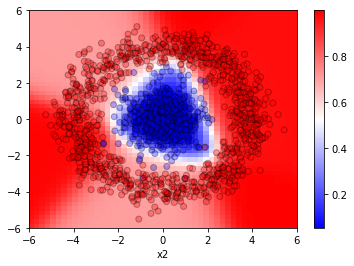

In [63]:
plt.pcolor(xgrid[:,0].reshape(50,50), xgrid[:,1].reshape(50,50), ygrid[:,1].reshape(50,50), cmap=cm.bwr, clim=[0,1])
plt.colorbar()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.3, cmap=plt.cm.bwr, edgecolors='k'); plt.xlabel('x1'), plt.xlabel('x2');

# The latent representation
As discussed, the key is the latent representation, i.e. the hidden layer of the MLP.
Let's have a look at it

In [64]:
# the slightly complicated way to get access to the activations of intermediate layers
Hmodel = Model(inputs=MLP.get_layer('input_layer').input, 
               outputs=MLP.get_layer('hidden_layer').output)
h = Hmodel.predict(X)  # that is the latent 3D representation of our data
h.shape

(2000, 3)

here's how it looks:

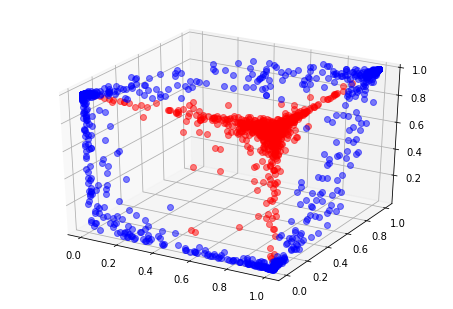

In [65]:
plot_3d(h, y)

- the MLP **learned a representation** where all blue datapoints are pushed into one corner of the cube.
- in this 3D representation, the two classes are **linearly separable**

## The latent representation during training
How does this latent representation change during training?
Here's a slightly hacky way to do a step-by-step gradient descend with keras recording the hidden layer (better use *callbacks*)

In [36]:
MLP = MLP_factory() 
MLP.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.01), 
              metrics=['accuracy'])

h_vector = []
for epoch in range(20):
    # get latent rep
    Hmodel = Model(inputs=MLP.get_layer('input_layer').input, 
                   outputs=MLP.get_layer('hidden_layer').output)
    h = Hmodel.predict(X)  # that is the latent 3D representation of our data
    h_vector.append(h)
    
    # update with one gradient step
    MLP.fit(X,to_categorical(y), epochs=1)

Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.6914 - acc: 0.4915     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.6621 - acc: 0.6990     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.5854 - acc: 0.8385     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.5061 - acc: 0.8430     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.4513 - acc: 0.8400     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.4176 - acc: 0.8410     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.3949 - acc: 0.8425     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.3553 - acc: 0.8540     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.2842 - acc: 0.8990     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.2144 - acc: 0.9705     
Epoch 1/1
2000/2000 [==============================] - 0s - loss: 0.1685 - acc: 

# alternatively: step by step GD in tensorflow
but using keras to define the layers. In tf, one would have to first implement the layer operations...

In [8]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

## model definitition
img = tf.placeholder(tf.float32, shape=(None, 2))
H = Dense(3, activation='sigmoid', name='hidden_layer')(img)
preds = Dense(2, activation='sigmoid', name='output_layer')(H)  # thats the predicted class scores
labels = tf.placeholder(tf.float32, shape=(None, 2))  # here , we feed in the true labels

from keras.objectives import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(labels, preds))  # just comparing prediction and truth

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [9]:
# Training
train_step = tf.train.AdamOptimizer(0.1).minimize(loss)

# Run training loop
h_vector = []
with sess.as_default():
    for i in range(100):
        h_tmp = sess.run(H,feed_dict={img: X})
        h_vector.append(h_tmp)
        train_step.run(feed_dict={img: X,
                                  labels: to_categorical(y,2)})

FailedPreconditionError: Attempting to use uninitialized value beta2_power_2
	 [[Node: beta2_power_2/read = Identity[T=DT_FLOAT, _class=["loc:@hidden_layer_3/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](beta2_power_2)]]

Caused by op 'beta2_power_2/read', defined at:
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-6a83ba88b9fc>", line 2, in <module>
    train_step = tf.train.AdamOptimizer(0.1).minimize(loss)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 129, in _create_slots
    trainable=False)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1679, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/michi/anaconda3/envs/py36_keras/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta2_power_2
	 [[Node: beta2_power_2/read = Identity[T=DT_FLOAT, _class=["loc:@hidden_layer_3/bias"], _device="/job:localhost/replica:0/task:0/cpu:0"](beta2_power_2)]]


0
1
2
3
4


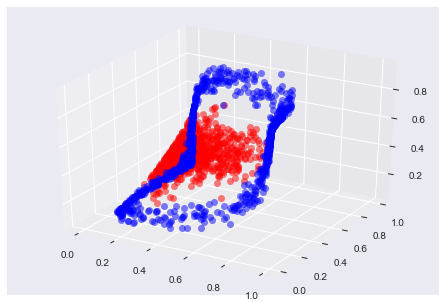

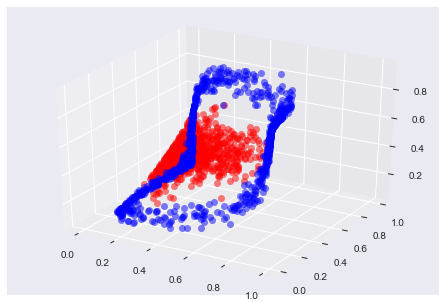

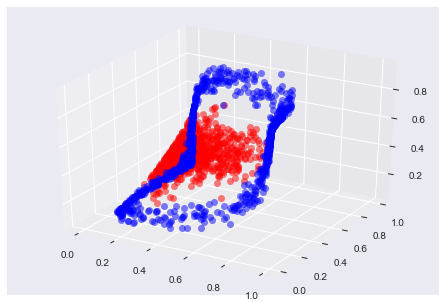

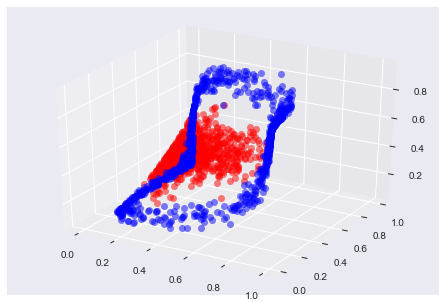

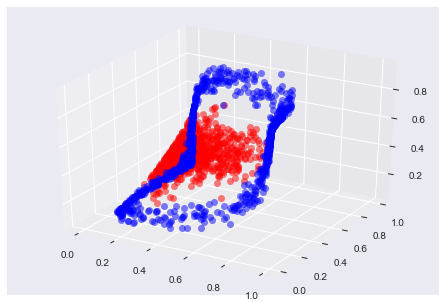

In [24]:
for ii,h in enumerate(h_vector[-5:]):
    print(ii)
    plot_3d(h_vector[-1], y)       

## animation
using holoviews to display the latent respresentation over time

In [37]:
import holoviews as hv
hv.extension('matplotlib')
scatter_dict = {i: hv.Scatter3D(h[y==0][:200])*hv.Scatter3D(h[y==1][:200]) for i,h in enumerate(h_vector[:200])} 
hmap = hv.HoloMap(scatter_dict, kdims=['Epoch'])
hmap